## 2) Implement a “grid search”

Investigate the follow parameters:

- activation units (sigmoid, relu, elu, etc.),

- different minimization algorithms (ADAM, RMSprop, Nesterov, etc.),

- different dropouts

- batch normalization

- different size or number of layers

In [ ]:
optimizer         = ['RMSprop', 'Adamax', 'Nadam', 'Adam']
hidden_activation = ['relu', 'tanh', 'softsign']
#N_epochs          = [400, 300, 200]
minibatch         = [50, 100]
l1 = []
l2 = []
l3 = []

for opt in optimizer:
    for act in hidden_activation:
        for batch in minibatch:
            l1.append(str(opt))
            l2.append(str(act))
            l3.append(str(batch))

l1 = " & ".join(l1)
l2 = " & ".join(l2)
l3 = " & ".join(l3)
print(f"{l1} \\\\\n {l2} \\\\\n {l3} ")

RMSprop & RMSprop & RMSprop & RMSprop & RMSprop & RMSprop & Adamax & Adamax & Adamax & Adamax & Adamax & Adamax & Nadam & Nadam & Nadam & Nadam & Nadam & Nadam & Adam & Adam & Adam & Adam & Adam & Adam \\
 relu & relu & tanh & tanh & softsign & softsign & relu & relu & tanh & tanh & softsign & softsign & relu & relu & tanh & tanh & softsign & softsign & relu & relu & tanh & tanh & softsign & softsign \\
 50 & 100 & 50 & 100 & 50 & 100 & 50 & 100 & 50 & 100 & 50 & 100 & 50 & 100 & 50 & 100 & 50 & 100 & 50 & 100 & 50 & 100 & 50 & 100 


In [ ]:
import tensorflow        as tf
import numpy             as np
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix

%load_ext autoreload
%autoreload 1
%aimport nn_model
%aimport create_data
%aimport preprocess
%aimport plot_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 2.1) Create dataset

In [ ]:
# number of data
N = 5000
# box size
B = 100

# random seed for reproducibility
np.random.seed(20220308)

x = create_data.sample_data(N, B)
y = create_data.assign_label(x)

mean = np.mean(x, axis=0)
std = np.std(x, axis=0)

# re-scaling data 
x_scaled = preprocess.standardize(x, mean, std)

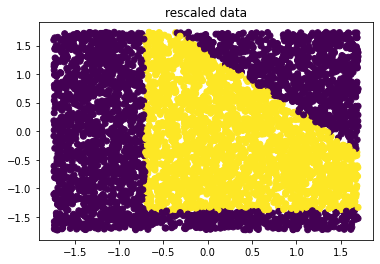

In [ ]:
plt.scatter(x_scaled[:,0], x_scaled[:,1], c=y)
plt.title("rescaled data")
plt.show()

In [ ]:
## SPLIT TRAIN  VALID AND TEST
train_test_frac  = 0.7
valid_train_frac = 0.2 

N_train = int(N*train_test_frac*(1-valid_train_frac))
N_valid = int(N*train_test_frac*valid_train_frac)
N_test  = int(N*(1-train_test_frac))

train_idx = N_train
valid_idx = N_train + N_valid
test_idx  = N_train + N_valid + N_test

x_train, y_train = np.copy(x_scaled[:train_idx]),  np.copy(y[:train_idx])
x_valid, y_valid = np.copy(x_scaled[train_idx:valid_idx]), np.copy(y[train_idx:valid_idx])
x_test,  y_test  = np.copy(x_scaled[valid_idx:test_idx]), np.copy(y[valid_idx:test_idx])

print(f"\nN_train :\t{x_train.shape[0]} \nN_valid :\t{x_valid.shape[0]} \nN_test :\t{x_test.shape[0]}")


N_train :	2800 
N_valid :	700 
N_test :	1500


### 2.2) Define NN and its architecture

In [ ]:
def create_model(
    n_features,
    neurons           = [20, 20, 1],
    dropout_arc       = [1],
    dropout_rates     = [0.2],
    hidden_activation = "relu",
    batch_norm_arc    = None,
    output_activation = "sigmoid",
    name              = "my lovely neural network",
    loss              = "binary_crossentropy",
    optimizer         = "adam",
    metrics           = ["accuracy"]
):
    # initialize architecture
    architecture = [n_features] + neurons
    input_dim    = n_features

    # create model
    network = nn_model.NN(
        input_dim         = input_dim,
        architecture      = architecture,
        dropout_layers    = dropout_arc,
        dropout_rates     = dropout_rates,
        batch_norm_layers = batch_norm_arc,
        hidden_activation = hidden_activation,
        output_activation = output_activation,
        nn_name           = name
    ) 

    # solves the "Model cannot be saved" issue
    network.compute_output_shape((None, input_dim))   
    
    network.compile(
        loss      = loss,
        optimizer = optimizer,
        metrics   = metrics,
    )
    return network

### 2.3) Modify the Hyperparameters to Optimize Performance of the Model

In [ ]:
minibatch = 50
N_epochs  = 100

model_gridsearch = KerasClassifier(build_fn=create_model, 
                                   n_features=x.shape[1], 
                                   epochs=N_epochs, 
                                   batch_size=minibatch)

/tmp/ipykernel_517/2038832178.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_gridsearch = KerasClassifier(build_fn=create_model,


#### 2.3.1) Grid Search CV
Tuning the
1)
- optimizer 
- (loss)
- hidden activation

2) architecture & dropout
- number of total neurons
- thin and long shape, fat and short shape, box shape
- dropout rates
- dropout layers

3) learning params
- epochs
- batch_size


In [ ]:
class GridSearch():

    def __init__(
        self, 
        x_train,
        y_train,
        model_gridsearch,
        param_grid,
        n_jobs=-1,
        cv=4,
        verbose=0
        ):
        
        self.x_train  = x_train
        self.y_train = y_train
        self.model_gridsearch    = model_gridsearch
        self.param_grid = param_grid
        self.n_jobs = n_jobs
        self.cv = cv
        self.verbose = verbose
        
    def get_result(self):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            grid = GridSearchCV(estimator=self.model_gridsearch, param_grid=self.param_grid, n_jobs=self.n_jobs, cv=self.cv, verbose=self.verbose)
            self.grid_result = grid.fit(self.x_train, self.y_train, verbose=self.verbose)
        return self.grid_result

    def print_result(self):
        print("Best: %f using %s" % (self.grid_result.best_score_, self.grid_result.best_params_))
        means = self.grid_result.cv_results_['mean_test_score']
        stds = self.grid_result.cv_results_['std_test_score']
        params = np.array(self.grid_result.cv_results_['params'])

        idx   = np.argsort(means)[::-1]
        means = means[idx]
        stds  = stds[idx]
        params = params[idx]

        for mean, stdev, param in zip(means, stds, params):
            print("%f (%f) with: %r" % (mean, stdev, param))

##### 1

In [ ]:
## OPTIMIZER
optimizer         = ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Nadam', 'Adamax', 'Ftrl']
param_grid = dict(optimizer         = optimizer)
grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

2022-03-15 09:28:17.115895: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-15 09:28:17.160505: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-15 09:28:17.193916: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuil

14/14 [==============================] - 0s 1ms/step - loss: 0.6891 - accuracy: 0.5757


GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa3898ed970>,
             n_jobs=-1,
             param_grid={'optimizer': ['SGD', 'RMSprop', 'Adam', 'Adadelta',
                                       'Adagrad', 'Nadam', 'Adamax', 'Ftrl']})

Best: 0.995714 using {'optimizer': 'Nadam'}
0.995714 (0.000000) with: {'optimizer': 'Nadam'}
0.994286 (0.003350) with: {'optimizer': 'RMSprop'}
0.992500 (0.005836) with: {'optimizer': 'Adam'}
0.988929 (0.002113) with: {'optimizer': 'Adamax'}
0.950000 (0.022968) with: {'optimizer': 'SGD'}
0.706071 (0.030845) with: {'optimizer': 'Adagrad'}
0.553929 (0.016884) with: {'optimizer': 'Ftrl'}
0.483929 (0.106940) with: {'optimizer': 'Adadelta'}


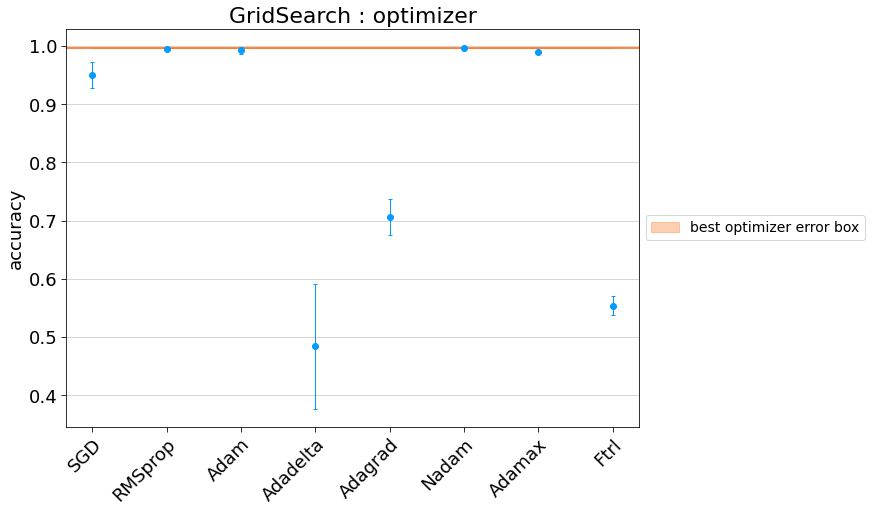

In [ ]:
grid.print_result()

key = "optimizer"

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    #colors     = palette,
    #labels     = " ",
    legend     = True,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
model_gridsearch = model_gridsearch.set_params(optimizer='Nadam')

In [ ]:
## HIDDEN ACTIVATION
hidden_activation = ['relu', 'elu', 'sigmoid', 'tanh', 'softmax', 'softsign', 'softplus', 'selu']
param_grid = dict(hidden_activation         = hidden_activation)
grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

14/14 [==============================] - 0s 1ms/step - loss: 0.1923 - accuracy: 0.9329


GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa3898ed970>,
             n_jobs=-1,
             param_grid={'hidden_activation': ['relu', 'elu', 'sigmoid', 'tanh',
                                               'softmax', 'softsign',
                                               'softplus', 'selu']})

Best: 0.995714 using {'hidden_activation': 'relu'}
0.995714 (0.003030) with: {'hidden_activation': 'relu'}
0.989286 (0.003847) with: {'hidden_activation': 'tanh'}
0.988571 (0.002020) with: {'hidden_activation': 'softsign'}
0.978929 (0.004670) with: {'hidden_activation': 'selu'}
0.978214 (0.005658) with: {'hidden_activation': 'elu'}
0.942143 (0.010127) with: {'hidden_activation': 'softplus'}
0.914643 (0.005658) with: {'hidden_activation': 'softmax'}
0.893571 (0.003273) with: {'hidden_activation': 'sigmoid'}


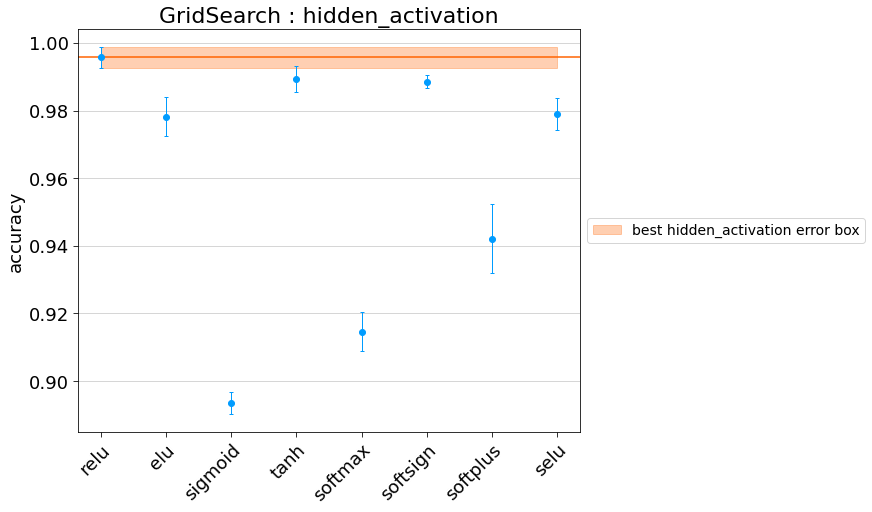

In [ ]:
grid.print_result()

key = "hidden_activation"

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    #colors     = palette,
    #labels     = " ",
    legend     = True,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
model_gridsearch = model_gridsearch.set_params(hidden_activation='relu')

In [ ]:
## check default loss
loss = ['binary_crossentropy']
param_grid = dict(loss = loss)
grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
default_loss_grid = grid.get_result()

14/14 [==============================] - 0s 1ms/step - loss: 0.0318 - accuracy: 0.9957


In [ ]:
grid.print_result()

Best: 0.995714 using {'loss': 'binary_crossentropy'}
0.995714 (0.001010) with: {'loss': 'binary_crossentropy'}


In [ ]:
## TRY hinge losses
loss = ['hinge', 'squared_hinge']
param_grid = dict(loss = loss)
y_train_hinge = y_train
y_train_hinge[y_train_hinge==0]=-1
grid = GridSearch(x_train, y_train_hinge, model_gridsearch, param_grid)
hinge_losses_grid = grid.get_result()

14/14 [==============================] - 0s 1ms/step - loss: 0.5834 - accuracy: 0.9714


In [ ]:
losses_grid = hinge_losses_grid.cv_results_
losses_grid["params"] = np.append(losses_grid["params"], default_loss_grid.cv_results_["params"][0])
losses_grid["mean_test_score"] = np.append(losses_grid["mean_test_score"], default_loss_grid.cv_results_["mean_test_score"][0])
losses_grid["std_test_score"] = np.append(losses_grid["std_test_score"], default_loss_grid.cv_results_["std_test_score"][0])

Best: 0.978929 using {'loss': 'squared_hinge'}
0.992857 (0.003642) with: {'loss': 'binary_crossentropy'}
0.978929 (0.006879) with: {'loss': 'squared_hinge'}
0.950357 (0.030662) with: {'loss': 'hinge'}


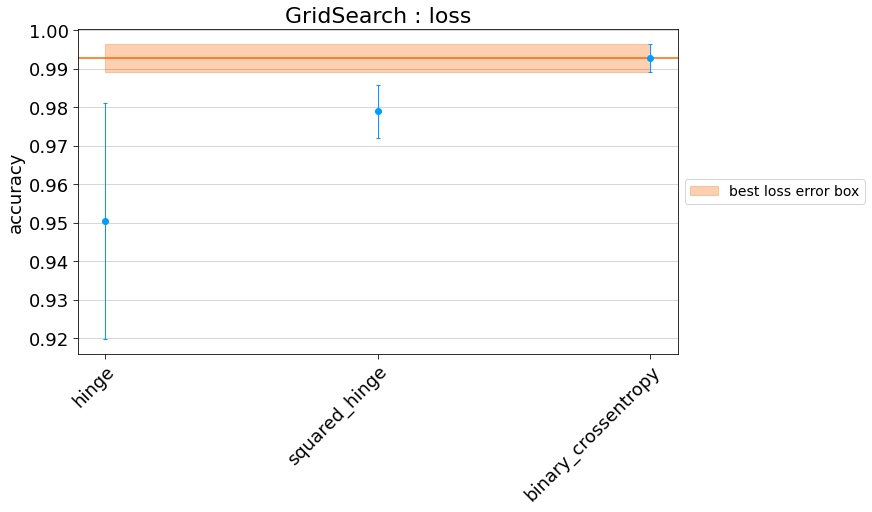

In [ ]:
grid.print_result()

key = "loss"

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    #colors     = palette,
    #labels     = " ",
    legend     = True,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
## TOT GRIDSEARCH
optimizer         = ['RMSprop', 'Adamax', 'Nadam', 'Adam']
hidden_activation = ['relu', 'tanh']

param_grid = dict(optimizer         = optimizer,
                  hidden_activation = hidden_activation)

grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

2022-03-15 10:19:46.664197: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-15 10:19:46.682487: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-15 10:19:46.690520: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuil

14/14 [==============================] - 0s 1ms/step - loss: 0.0536 - accuracy: 0.9900


GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa3898ed970>,
             n_jobs=-1,
             param_grid={'hidden_activation': ['relu', 'tanh'],
                         'optimizer': ['RMSprop', 'Adamax', 'Nadam', 'Adam']})

Best: 0.994286 using {'hidden_activation': 'relu', 'optimizer': 'Nadam'}
0.994286 (0.004165) with: {'hidden_activation': 'relu', 'optimizer': 'Nadam'}
0.993571 (0.004574) with: {'hidden_activation': 'relu', 'optimizer': 'Adam'}
0.992143 (0.004345) with: {'hidden_activation': 'relu', 'optimizer': 'RMSprop'}
0.990000 (0.003499) with: {'hidden_activation': 'tanh', 'optimizer': 'Adam'}
0.989643 (0.003407) with: {'hidden_activation': 'tanh', 'optimizer': 'Nadam'}
0.983929 (0.005658) with: {'hidden_activation': 'tanh', 'optimizer': 'RMSprop'}
0.983571 (0.003847) with: {'hidden_activation': 'relu', 'optimizer': 'Adamax'}
0.943929 (0.015399) with: {'hidden_activation': 'tanh', 'optimizer': 'Adamax'}


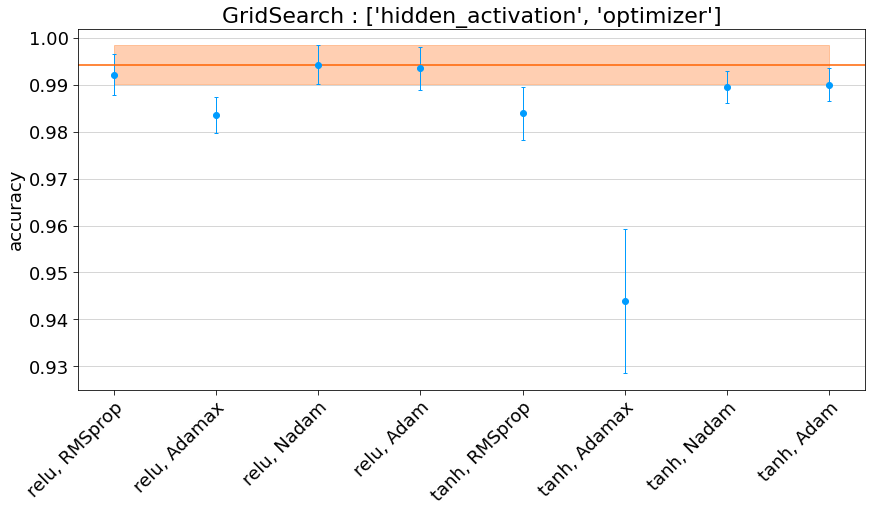

In [ ]:
grid.print_result()

key = ["hidden_activation", "optimizer"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    #colors     = palette,
    #labels     = " ",
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
model_gridsearch = model_gridsearch.set_params(hidden_activation='relu', optimizer='Nadam')

#### 2

In [ ]:
## DIFFERENT NN SHAPES
neurons        = [ [20,20,1], [4 for i in range(10)]+[1], [6 for i in range(6)]+[1]]

param_grid = dict(neurons        = neurons)

grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

14/14 [==============================] - 0s 2ms/step - loss: 0.6864 - accuracy: 0.5586


GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa3898ed970>,
             n_jobs=-1,
             param_grid={'neurons': [[20, 20, 1],
                                     [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1],
                                     [6, 6, 6, 6, 6, 6, 1]]})

Best: 0.994643 using {'neurons': [20, 20, 1]}
0.994643 (0.002113) with: {'neurons': [20, 20, 1]}
0.889286 (0.016736) with: {'neurons': [6, 6, 6, 6, 6, 6, 1]}
0.790714 (0.135863) with: {'neurons': [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1]}


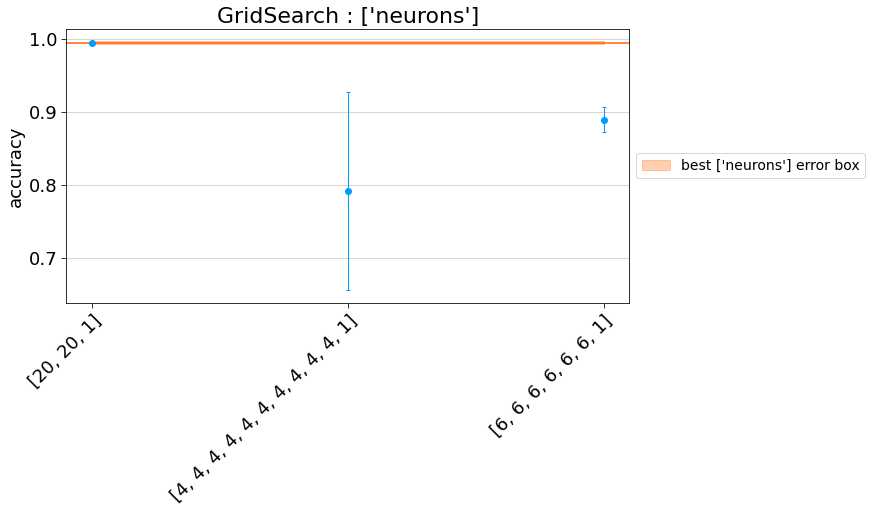

In [ ]:
grid.print_result()

key = ["neurons"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    #colors     = palette,
    #labels     = " ",
    legend     = True,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
## DIFFERENT N of NEURONS
neurons        = [[5,5,1], [20,20,1], [100,100,1], [500,500,1]]
param_grid = dict(neurons        = neurons)
grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

14/14 [==============================] - 0s 4ms/step - loss: 0.0156 - accuracy: 0.9943


GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa3898ed970>,
             n_jobs=-1,
             param_grid={'neurons': [[5, 5, 1], [20, 20, 1], [100, 100, 1],
                                     [500, 500, 1]]})

Best: 0.993214 using {'neurons': [100, 100, 1]}
0.993214 (0.005285) with: {'neurons': [100, 100, 1]}
0.992143 (0.004226) with: {'neurons': [20, 20, 1]}
0.991786 (0.002551) with: {'neurons': [500, 500, 1]}
0.933571 (0.031952) with: {'neurons': [5, 5, 1]}


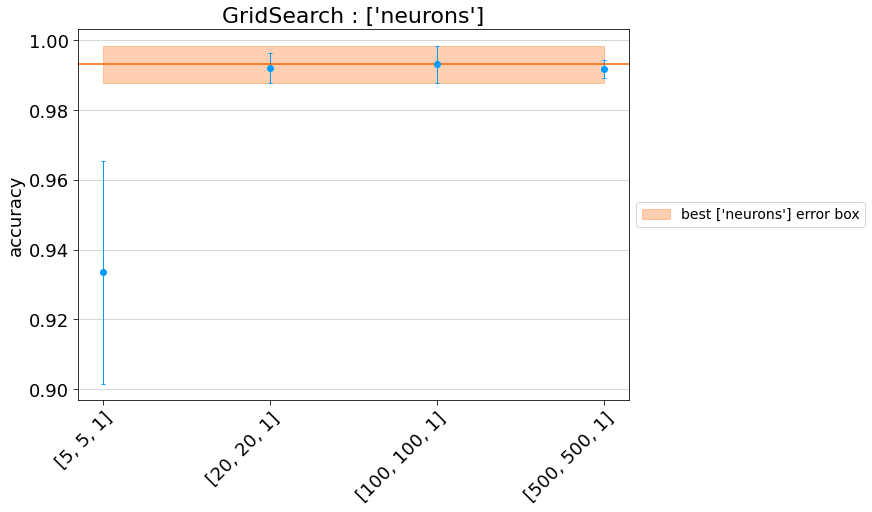

In [ ]:
grid.print_result()

key = ["neurons"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    #colors     = palette,
    #labels     = " ",
    legend     = True,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
model_gridsearch = model_gridsearch.set_params(neurons=[100, 100, 1])

In [ ]:
## DROPOUT PARAMS
dropout_rates        = [[i/10] for i in range(6)]
dropout_layers       = [[1], [2]]

param_grid = dict(dropout_rates        = dropout_rates,
                  dropout_arc          = dropout_layers)
grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

14/14 [==============================] - 0s 1ms/step - loss: 0.0212 - accuracy: 0.9929


GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa3898ed970>,
             n_jobs=-1,
             param_grid={'dropout_arc': [[1], [2]],
                         'dropout_rates': [[0.0], [0.1], [0.2], [0.3], [0.4],
                                           [0.5]]})

Best: 0.993214 using {'dropout_arc': [2], 'dropout_rates': [0.5]}
0.993214 (0.001557) with: {'dropout_arc': [2], 'dropout_rates': [0.5]}
0.993214 (0.002743) with: {'dropout_arc': [1], 'dropout_rates': [0.0]}
0.992857 (0.003499) with: {'dropout_arc': [2], 'dropout_rates': [0.4]}
0.992857 (0.002673) with: {'dropout_arc': [2], 'dropout_rates': [0.1]}
0.992857 (0.004403) with: {'dropout_arc': [1], 'dropout_rates': [0.5]}
0.992857 (0.003642) with: {'dropout_arc': [1], 'dropout_rates': [0.3]}
0.992500 (0.001557) with: {'dropout_arc': [2], 'dropout_rates': [0.2]}
0.992500 (0.004778) with: {'dropout_arc': [1], 'dropout_rates': [0.4]}
0.992500 (0.002113) with: {'dropout_arc': [1], 'dropout_rates': [0.1]}
0.992500 (0.002342) with: {'dropout_arc': [2], 'dropout_rates': [0.3]}
0.991429 (0.006624) with: {'dropout_arc': [2], 'dropout_rates': [0.0]}
0.991071 (0.004778) with: {'dropout_arc': [1], 'dropout_rates': [0.2]}


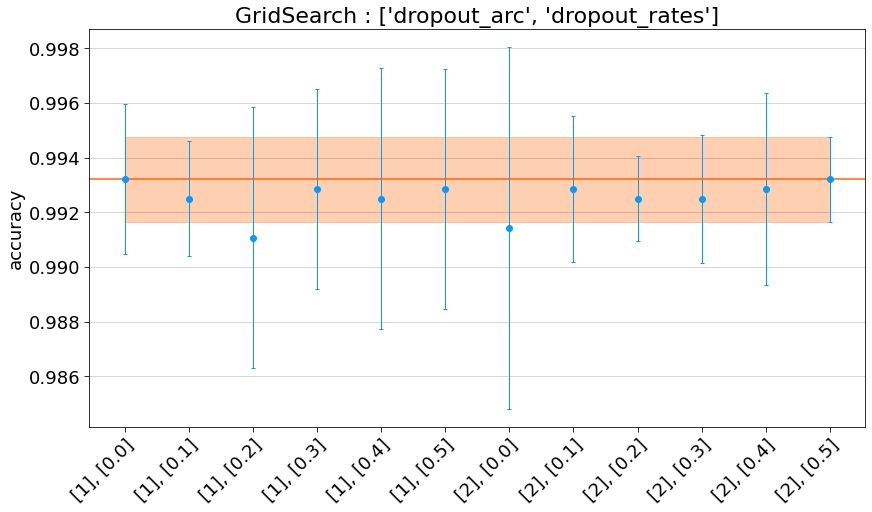

In [ ]:
grid.print_result()

key = ["dropout_arc", "dropout_rates"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    #colors     = palette,
    #labels     = " ",
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
## TOT GRID
neurons              = [[100, 100,1], [20,20,1], [500,500,1]]
dropout_rates        = [[i/10] for i in range(6)]
dropout_layers       = [[1], [2]]

param_grid = dict(neurons        = neurons,
                  dropout_rates  = dropout_rates,
                  dropout_arc    = dropout_layers)

grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

14/14 [==============================] - 0s 3ms/step - loss: 0.0076 - accuracy: 0.9986


GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa3898ed970>,
             n_jobs=-1,
             param_grid={'dropout_arc': [[1], [2]],
                         'dropout_rates': [[0.0], [0.1], [0.2], [0.3], [0.4],
                                           [0.5]],
                         'neurons': [[100, 100, 1], [20, 20, 1],
                                     [500, 500, 1]]})

Best: 0.996429 using {'dropout_arc': [1], 'dropout_rates': [0.2], 'neurons': [20, 20, 1]}
0.996429 (0.002143) with: {'dropout_arc': [1], 'dropout_rates': [0.2], 'neurons': [20, 20, 1]}
0.995357 (0.002113) with: {'dropout_arc': [2], 'dropout_rates': [0.5], 'neurons': [500, 500, 1]}
0.995357 (0.002113) with: {'dropout_arc': [1], 'dropout_rates': [0.5], 'neurons': [100, 100, 1]}
0.994643 (0.002743) with: {'dropout_arc': [1], 'dropout_rates': [0.2], 'neurons': [100, 100, 1]}
0.994643 (0.002551) with: {'dropout_arc': [1], 'dropout_rates': [0.1], 'neurons': [20, 20, 1]}
0.994286 (0.003350) with: {'dropout_arc': [2], 'dropout_rates': [0.2], 'neurons': [20, 20, 1]}
0.994286 (0.004165) with: {'dropout_arc': [1], 'dropout_rates': [0.4], 'neurons': [20, 20, 1]}
0.994286 (0.002259) with: {'dropout_arc': [2], 'dropout_rates': [0.0], 'neurons': [100, 100, 1]}
0.994286 (0.001010) with: {'dropout_arc': [2], 'dropout_rates': [0.0], 'neurons': [20, 20, 1]}
0.994286 (0.002259) with: {'dropout_arc': [1], 

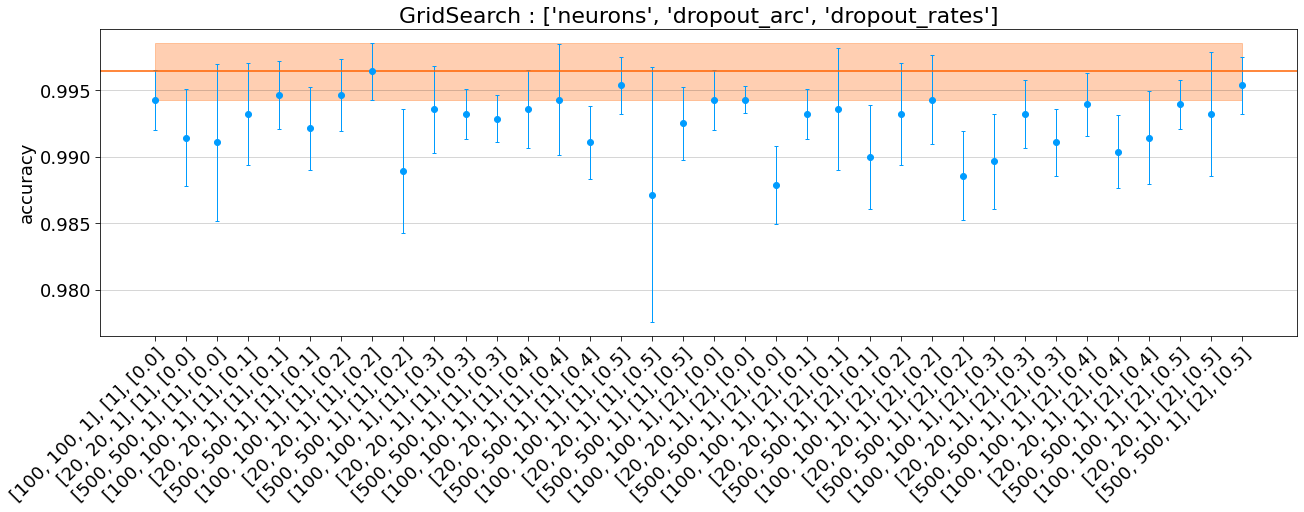

In [ ]:
grid.print_result()

key = ["neurons", "dropout_arc", "dropout_rates"]

fig = plt.figure(figsize=(18,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    #colors     = palette,
    #labels     = " ",
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
model_gridsearch = model_gridsearch.set_params(dropout_arc=[1], dropout_rates=[0.2], neurons=[20, 20, 1])

#### 3

In [ ]:
## EPOCHS
N_epochs        = [10, 50, 100, 200, 300, 400]

param_grid = dict(epochs        = N_epochs)

grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

2022-03-15 11:00:19.807708: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-15 11:00:19.816800: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-15 11:00:19.957221: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuil

14/14 [==============================] - 0s 1ms/step - loss: 0.0144 - accuracy: 0.9929


GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa3898ed970>,
             n_jobs=-1, param_grid={'epochs': [10, 50, 100, 200, 300, 400]})

Best: 0.996786 using {'epochs': 300}
0.996786 (0.001856) with: {'epochs': 300}
0.995000 (0.002945) with: {'epochs': 400}
0.995000 (0.002143) with: {'epochs': 200}
0.993929 (0.008105) with: {'epochs': 100}
0.993571 (0.001597) with: {'epochs': 50}
0.897143 (0.041157) with: {'epochs': 10}


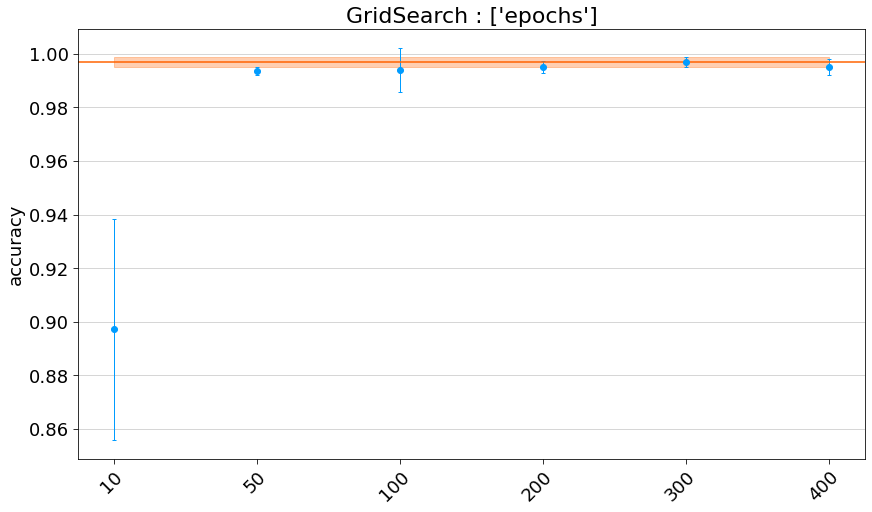

In [ ]:
grid.print_result()

key = ["epochs"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    #colors     = palette,
    #labels     = " ",
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
model_gridsearch = model_gridsearch.set_params(epochs=300)

In [ ]:
## BATCH_SIZE
minibatch        = [N_train, 50, 100, 250, 500 , 1000]

param_grid = dict(batch_size        = minibatch)

grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

1/1 [==============================] - 0s 77ms/step - loss: 0.0881 - accuracy: 0.9843


GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa3898ed970>,
             n_jobs=-1,
             param_grid={'batch_size': [2800, 50, 100, 250, 500, 1000]})

Best: 0.996786 using {'batch_size': 50}
0.996786 (0.001557) with: {'batch_size': 50}
0.995714 (0.003642) with: {'batch_size': 100}
0.994643 (0.003554) with: {'batch_size': 500}
0.993214 (0.003093) with: {'batch_size': 250}
0.989643 (0.003254) with: {'batch_size': 1000}
0.949286 (0.026983) with: {'batch_size': 2800}


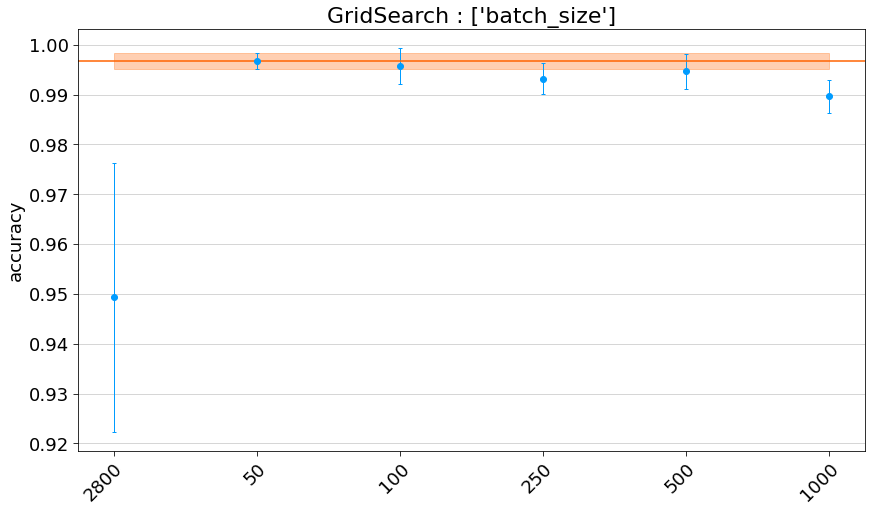

In [ ]:
grid.print_result()

key = ["batch_size"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    #colors     = palette,
    #labels     = " ",
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
model_gridsearch = model_gridsearch.set_params(batch_size=50)

In [ ]:
N_epochs        = [400, 300, 200]
minibatch        = [50, 100, 250, 500]


param_grid = dict(epochs        = N_epochs,
                  batch_size     = minibatch)

grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

14/14 [==============================] - 0s 2ms/step - loss: 0.0124 - accuracy: 0.9971


14/14 [==============================] - 0s 2ms/step - loss: 0.0225 - accuracy: 0.9886


2/2 [==============================] - 0s 2ms/step - loss: 0.0739 - accuracy: 0.9929


2/2 [==============================] - 0s 2ms/step - loss: 0.0507 - accuracy: 0.9900


GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa3898ed970>,
             n_jobs=-1,
             param_grid={'batch_size': [50, 100, 250, 500],
                         'epochs': [400, 300, 200]})

Best: 0.997857 using {'batch_size': 100, 'epochs': 400}
0.997857 (0.001597) with: {'batch_size': 100, 'epochs': 400}
0.996786 (0.003961) with: {'batch_size': 100, 'epochs': 300}
0.996071 (0.002923) with: {'batch_size': 50, 'epochs': 200}
0.996071 (0.004446) with: {'batch_size': 250, 'epochs': 300}
0.995714 (0.001429) with: {'batch_size': 100, 'epochs': 200}
0.995000 (0.003273) with: {'batch_size': 500, 'epochs': 300}
0.995000 (0.002575) with: {'batch_size': 50, 'epochs': 400}
0.995000 (0.005487) with: {'batch_size': 250, 'epochs': 400}
0.993929 (0.002923) with: {'batch_size': 500, 'epochs': 400}
0.993214 (0.002113) with: {'batch_size': 250, 'epochs': 200}
0.992857 (0.001750) with: {'batch_size': 500, 'epochs': 200}
0.992857 (0.003642) with: {'batch_size': 50, 'epochs': 300}


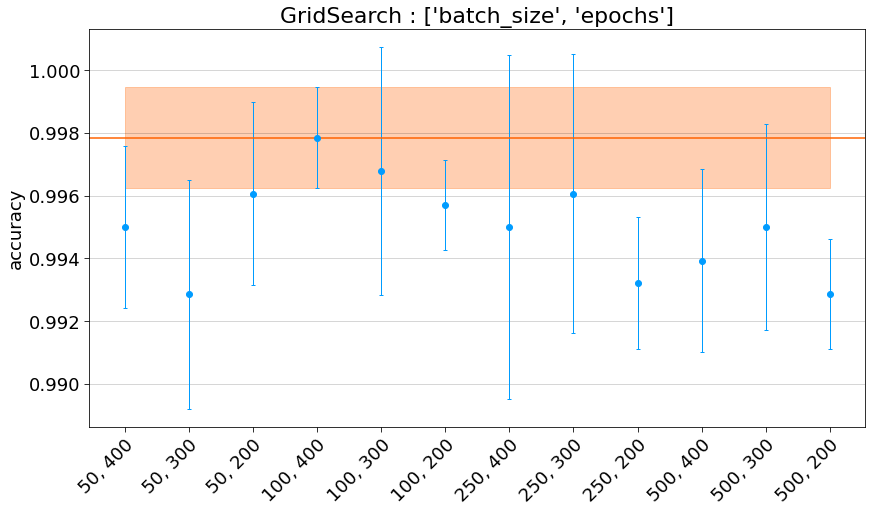

In [ ]:
grid.print_result()

key = ["batch_size", "epochs"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    #colors     = palette,
    #labels     = " ",
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
model_gridsearch = model_gridsearch.set_params(epochs=400, batch_size=100)

### Test score with tuned hyperparameters

In [ ]:
# check current model
model_gridsearch.get_params()

{'n_features': 2,
 'epochs': 400,
 'batch_size': 100,
 'optimizer': 'Nadam',
 'hidden_activation': 'relu',
 'neurons': [20, 20, 1],
 'dropout_arc': [1],
 'dropout_rates': [0.2],
 'build_fn': <function __main__.create_model(n_features, neurons=[20, 20, 1], dropout_arc=[1], dropout_rates=[0.2], hidden_activation='relu', batch_norm_arc=None, output_activation='sigmoid', name='my lovely neural network', loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])>}

In [ ]:
fit = model_gridsearch.fit(x_train, y_train, validation_data=(x_valid, y_valid))

Epoch 1/400
28/28 [==============================] - 1s 7ms/step - loss: 0.7086 - accuracy: 0.4607 - val_loss: 0.6688 - val_accuracy: 0.5871
Epoch 2/400
28/28 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6207 - val_loss: 0.6168 - val_accuracy: 0.6743
Epoch 3/400
28/28 [==============================] - 0s 3ms/step - loss: 0.6008 - accuracy: 0.6604 - val_loss: 0.5781 - val_accuracy: 0.6957
Epoch 4/400
28/28 [==============================] - 0s 3ms/step - loss: 0.5598 - accuracy: 0.7054 - val_loss: 0.5373 - val_accuracy: 0.7329
Epoch 5/400
28/28 [==============================] - 0s 2ms/step - loss: 0.5210 - accuracy: 0.7404 - val_loss: 0.4982 - val_accuracy: 0.7571
Epoch 6/400
28/28 [==============================] - 0s 2ms/step - loss: 0.4920 - accuracy: 0.7618 - val_loss: 0.4619 - val_accuracy: 0.7800
Epoch 7/400
28/28 [==============================] - 0s 2ms/step - loss: 0.4600 - accuracy: 0.7807 - val_loss: 0.4277 - val_accuracy: 0.8129
Epoch 8/400
2

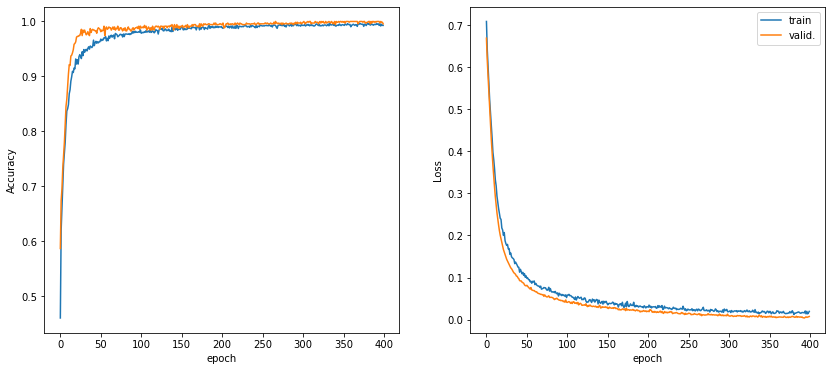

In [ ]:
fig,AX=plt.subplots(1,2,figsize=(14,6.))
ax=AX[0]
ax.plot(fit.history['accuracy'],label="train")
ax.plot(fit.history['val_accuracy'],label="valid.")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax=AX[1]
ax.plot(fit.history['loss'],label="train")
ax.plot(fit.history['val_loss'],label="valid.")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

In [ ]:
y_pred =model_gridsearch.predict(x_test)

pred_binary = y_pred.copy()
pred_binary[y_pred <= 0.5] = 0
pred_binary[y_pred >  0.5] = 1

cm = confusion_matrix(y_test, plot_utils.flatten(pred_binary))

/mnt/c/Users/giaco/Documents/Uni/PoD/LCP/modB/LCP_modB/02-DNN/plot_utils.py:29: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


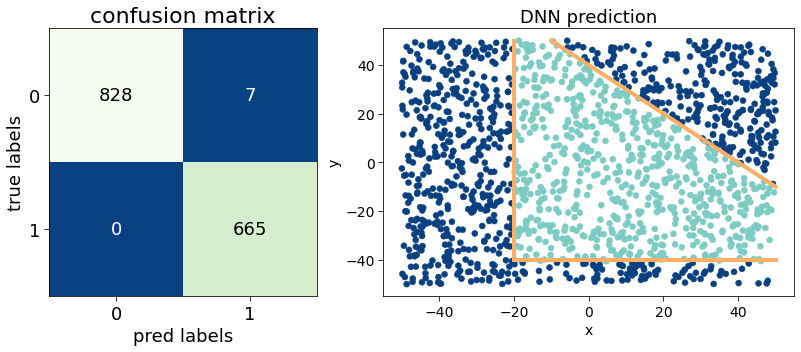

In [ ]:
fig = plt.figure(figsize=(12,5), constrained_layout=True)

ax = fig.add_subplot(121)

total_0, total_1 =  np.sum(cm, axis=1)
 
cm_norm_0 = cm[0]/total_0
cm_norm_1 = cm[1]/total_1

cm_norm = np.vstack((cm_norm_0, cm_norm_1))

plot_utils.plot_confusion_matrix(
    cm = cm,
    ax = ax,
    title = "confusion matrix"
)

# scale back x data
mean = np.mean(x, axis=0)
std = np.std(x, axis=0)

ax  = plot_utils.plot_labeled_data(
        x               = x_test*std+mean, 
        labels          = plot_utils.flatten(y_pred), 
        fig             = fig, 
        subplot_id      = 122,
        title           = "DNN prediction", 
        palette         = "GnBu_r",
        hue_norm        = (0, 2),
        fontsize        = 14, 
        legend          = False 
    )
plot_utils.boundaries(ax)
    
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=452e6836-b7b8-455e-80d9-d4109b6baddf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>